# <center>Đồ án 3: Linear Regression</center>

# Thông tin sinh viên

- Họ và tên: Huỳnh Sỉ Kha
- MSSV: 21127734
- Lớp: 21CLC02

# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# 1D
# Model1
from itertools import combinations
# Model2: XGBOOST
from sklearn.model_selection import train_test_split
import xgboost as xgb
# Model3: Genetic Algorithm
import random

# Đọc dữ liệu

In [2]:
# Đọc dữ liệu bằng pandas
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]    # Dataframe (chứa các đặc trưng huấn luyện) 
y_train = train.iloc[:, -1]     # Series    (chứa 1 giá trị mục tiêu kiểm tra)
# .loc["Gender", ...]:  lấy theo tên cột
# .iloc[:, :11]: lấy theo vị trí.

X_test = test.iloc[:, :-1]      # Dataframe (chứa các đặc trưng kiểm tra)
y_test = test.iloc[:, -1]       # Series    (chứa 1 giá trị mục tiêu kiểm tra)

# Sinh viên có thể sử dụng các khác nếu cần

# Cài đặt hàm

In [3]:
# Cài đặt các hàm cần thiết ở đây
class LinearRegression:
    def fit(self, X, y):
        X_pinv = np.linalg.pinv(X)
        self.w = X_pinv @ y
        
        return self

    def get_params(self):
        return self.w

    def predict(self, X):
        return np.sum(self.w.ravel() * X, axis=1)

def MAE(y, y_hat):
    return np.mean(np.abs(y.ravel() - y_hat.ravel()))

def calc_MAE_with_features(kFold, features):
    for train_index, test_index in kFold.split(X_train):
        y_features_train, y_features_test = y_train[train_index], y_train[test_index]

        for i in features.keys():
            x_features_train = X_train.loc[train_index, [i]]
            x_features_test = X_train.loc[test_index, [i]]

            lr = LinearRegression().fit(x_features_train, y_features_train)
 
            y_pred = lr.predict(x_features_test)

            features[i].append(MAE(y_features_test, y_pred))
    
    return features

# Yêu cầu 1a: Sử dụng toàn bộ 11 đặc trưng đầu tiên `Gender`, `10percentage`, `12percentage`, `CollegeTier`, `Degree`, `collegeGPA`, `CollegeCityTier`, `English`, `Logical`, `Quant`, `Domain` (2 điểm) 

In [4]:
# Phần code cho yêu cầu 1a
a_column = ["Gender", "10percentage", "12percentage", "CollegeTier", "Degree", "collegeGPA", "CollegeCityTier", "English", "Logical", "Quant", "Domain"]

X_1a_train = X_train.loc[:, a_column]
Y_1a_train = y_train

X_1a_test = X_test.loc[:, a_column]
Y_1a_test = y_test

# Training model
lr = LinearRegression().fit(X_1a_train, Y_1a_train)

# Predict
y_hat = lr.predict(X_1a_test)


In [5]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra
print("MAE: ", MAE(Y_1a_test, y_hat))
# print(lr.get_params())

MAE:  104863.77754033144


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = -22756.513 * Gender + 804.503 * 10percentage + 1294.655 * 12percentage - 91781.898 * CollegeTier \\ + 23182.389 * Degree + 1437.549 * collegeGPA - 8570.663 * CollegeCityTier + 147.858 * English + 152.888 * Logical \\ + 117.222 * Quant + 34552.286 * Domain$$

# Yêu cầu 1b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng tính cách với các đặc trưng tính cách gồm `conscientiousness`, `agreeableness`, `extraversion`, `nueroticism`, `openess_to_experience`, tìm mô hình cho kết quả tốt nhất (1 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [6]:
def find_best_model(model:dict):
    min_mean = float("inf") 
    best_key = None
    
    for key, values in model.items():
        mean = np.mean(values)
        if mean < min_mean:
            min_mean = mean 
            best_key = key 
    return min_mean, best_key

In [7]:
# Phần code cho yêu cầu 1b
splits = 5
kf = KFold(n_splits=splits, shuffle=True, random_state=39)

b_column = {"conscientiousness" : [],
            "agreeableness" : [],
            "extraversion" : [],
            "nueroticism" : [],
            "openess_to_experience" : []}

b_column = calc_MAE_with_features(kf, b_column)
        
# Tìm ra đặc trưng tốt nhất
best_value, best_personality_feature_model = find_best_model(b_column)
print("Best_personality_feature_model: ", best_value, best_personality_feature_model)

# In ra các kết quả cross-validation như yêu cầu
print("\nCross-validation results:")
for i in b_column.keys():
    print(i, ": ", np.mean(b_column[i]))


Best_personality_feature_model:  299292.7309212932 nueroticism

Cross-validation results:
conscientiousness :  306173.2772087398
agreeableness :  300862.5475420066
extraversion :  306854.2364803871
nueroticism :  299292.7309212932
openess_to_experience :  303083.9046157337


In [8]:
# Huấn luyện lại mô hình best_personality_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
x_1b_train = X_train.loc[:, [best_personality_feature_model]]
x_1b_test = X_test.loc[:, [best_personality_feature_model]]

lr = LinearRegression().fit(x_1b_train, y_train)

In [9]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_personality_feature_model
y_pred = lr.predict(x_1b_test)
print("MAE: ", MAE(y_test, y_pred))
# print(lr.get_params())

MAE:  291019.693226953


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = -56546.308 * nueroticism$$

# Yêu cầu 1c: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng `English`, `Logical`, `Quant`, tìm mô hình cho kết quả tốt nhất (1 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [10]:
# Phần code cho yêu cầu 1c
c_column = {"English" : [],
            "Logical" : [],
            "Quant" : []}

c_column = calc_MAE_with_features(kf, c_column)

# Tìm ra đặc trưng tốt nhất
best_value, best_skill_feature_model = find_best_model(c_column)
print("Best_skill_feature_model: ", best_value, best_skill_feature_model)

# In ra các kết quả cross-validation như yêu cầu
print("\nCross-validation results:")
for i in c_column.keys():
    print(i, ": ", np.mean(c_column[i]))

Best_skill_feature_model:  118051.21667524746 Quant

Cross-validation results:
English :  121873.90116281415
Logical :  120269.53069288726
Quant :  118051.21667524746


In [11]:
# Huấn luyện lại mô hình best_skill_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
x_1c_train = X_train.loc[:, [best_skill_feature_model]]
x_1c_test = X_test.loc[:, [best_skill_feature_model]]

lr = LinearRegression().fit(x_1c_train, y_train)

In [12]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_skill_feature_model
y_pred = lr.predict(x_1c_test)
print("MAE: ", MAE(y_test, y_pred))
# print(lr.get_params())

MAE:  106819.5776198967


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = 585.895 * Quant$$

# Yêu cầu 1d: Sinh viên tự xây dựng mô hình, tìm mô hình cho kết quả tốt nhất (3 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ $m$ mô hình mà sinh viên thiết kế

## Tìm mô hình

### Mô hình 1: Kết hợp từ 1a, 1b, 1c
- Gọi hàm bruteforce() để tìm ra tổ hợp các đặc trưng cho kết quả MAE tốt nhất từ các mô hình:
    - Mô hình câu 1a, 1b, 1c + Mô hình 7 đặc trưng về điểm số trong phần kỹ thuật.
    - Gọi lần lượt cho từng mô hình nhằm tránh hiện tượng thời gian chạy quá lâu.
- Sau đó kết hợp các kết quả trên để tạo ra 1 mô hình, rồi huấn luyện và thử nghiệm lại trên tập kiểm thử.

In [13]:
# Brute force
def find_best_feature_combination(X_train, y_train, features):
    best_mae = float('inf')
    best_feature_combination = []

    # Loop through all possible combinations of features
    for r in range(1, len(features) + 1):
        for combo in combinations(features, r):
            selected_features = list(combo)

            x_features_train = X_train[selected_features]
            lr = LinearRegression().fit(x_features_train, y_train)
            y_pred = lr.predict(X_test[selected_features])
            mae = MAE(y_test, y_pred)

            if mae < best_mae:
                best_mae = mae
                best_feature_combination = selected_features

    return best_mae, best_feature_combination


# Create a dictionary of features to try
# Seperate features into 1a, 1b, 1c for optimal time complexity.
features_to_try = ["Gender", "10percentage", "CollegeTier", "Degree", "collegeGPA", "CollegeCityTier", "Quant", "Domain", 
                   "ComputerProgramming", "ElectronicsAndSemicon", "ComputerScience", "MechanicalEngg", "ElectricalEngg", "TelecomEngg", "CivilEngg",
                   "conscientiousness", "agreeableness", "extraversion", "nueroticism", "openess_to_experience"]

# Loop all features, calculate MAE and return the best combination
# best_mae, best_features = find_best_feature_combination(X_train, y_train, features_to_try)

In [14]:
# Result of the 1st model
model_1st =  ["10percentage", "12percentage", "CollegeTier", "collegeGPA", "CollegeCityTier", "Quant", "Domain", "ComputerProgramming", "ElectronicsAndSemicon", "ComputerScience",
             "MechanicalEngg", "conscientiousness", "agreeableness", "nueroticism", "openess_to_experience"]

### Mô hình 2: Sử dụng thuật toán XG-BOOST
- Chạy thuật toán XG-BOOST với các tham số mặc định. 
- Đánh giá mô hình bằng các độ đo: F1-score.
- Chọn ra các đặc trưng có đóng góp trên 15% vào mô hình.
- Huấn luyện trên mô hình đó và kiểm thử.

MAE:  104182.43802083333


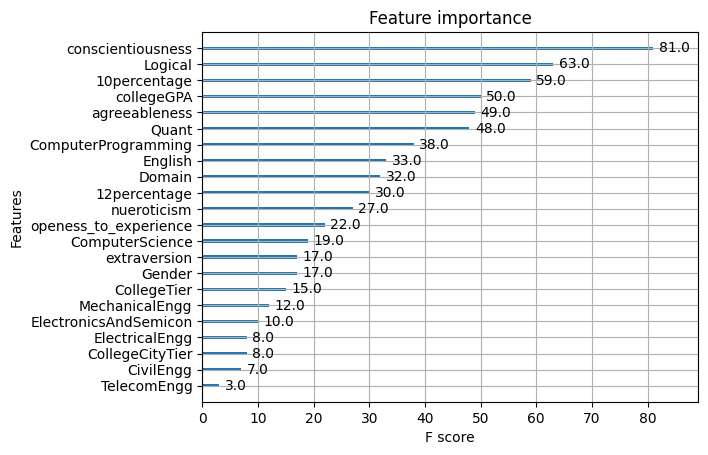

In [15]:
# Build model with XGBoost
model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)

# Train model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate model
print("MAE: ", MAE(y_test, y_pred))

# Plot feature importance
xgb.plot_importance(model)
plt.show()

In [16]:
# Result of 3rd model
model_2nd = ["conscientiousness", "Logical", "10percentage", "collegeGPA", "agreeableness", 
            "Quant", "ComputerProgramming", "English", "Domain", "12percentage",
            "nueroticism", "openess_to_experience", "ComputerScience", "extraversion",
            "Gender", "CollegeTier"]

### Mô hình 3: Genetic Algorithm
- Cài đặt thuật toán Genetic để tìm ra tổ hợp cho kết quả MAE tốt trong 23 mô hình ban đầu.
- Huấn luyện trên mô hình đó và đánh giá kết quả.

In [17]:
# Number of individuals in a population
population_size = 50

# Number of generations
num_generations = 50

features = ["Gender", "10percentage", "12percentage", "CollegeTier",
            "Degree", "collegeGPA", "CollegeCityTier", 
            "English", "Logical", "Quant", "Domain", "ComputerProgramming", "ElectronicsAndSemicon", 
            "ComputerScience", "MechanicalEngg", "ElectricalEngg", "TelecomEngg", "CivilEngg", "conscientiousness", 
            "agreeableness", "extraversion", "nueroticism", "openess_to_experience"]

# Evaluate the fitness of an individual by calculating MAE of a linear regression model
def evaluate_solution(solution):
    selected_feature_indices = [i for i, selected in enumerate(solution) if selected == 1]
    X_train_selected = X_train.iloc[:, selected_feature_indices]
    X_test_selected = X_test.iloc[:, selected_feature_indices]
    
    lr = LinearRegression().fit(X_train_selected, y_train)
    y_pred = lr.predict(X_test_selected)
    mae = MAE(y_test, y_pred)
    return mae

# Initialize the population
population = [np.random.randint(2, size=len(features)) for _ in range(population_size)]

# Evolve the population
for generation in range(num_generations):
    # Evaluate the fitness of each individual
    fitness_scores = [evaluate_solution(solution) for solution in population]
    
    # Choose the best individual
    best_solution_index = np.argmin(fitness_scores)
    best_solution = population[best_solution_index]
    
    # Generate a new population by crossover and mutation
    new_population = []
    for _ in range(population_size):
        parent1 = random.choice(population)
        parent2 = random.choice(population)

        crossover_point = np.random.randint(1, len(features) - 1)

        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        if np.random.rand() < 0.1:  # Chance of mutation is 10%
            mutation_point = np.random.randint(len(features))
            child[mutation_point] = 1 - child[mutation_point]
        new_population.append(child)
    
    # Replace the old population with the new population
    population = new_population
    
# Evaluate the fitness of each individual

# best_solution = population[best_solution_index]
# best_features = [feature for i, feature in enumerate(features) if best_solution[i] == 1]
# print("Best feature combination:", best_features)

In [18]:
# Result of the 4th model
model_3rd = ['10percentage', '12percentage', 'collegeGPA', 'English', 'Quant',
              'ComputerProgramming', 'ElectronicsAndSemicon', 'ComputerScience',
              'MechanicalEngg', 'conscientiousness', 'agreeableness', 'extraversion',
              'nueroticism', 'openess_to_experience']


## Thử nghiệm, so sánh các mô hình

In [19]:
def calc_MAE_with_features_2(kFold, features):
    for train_index, test_index in kFold.split(X_train):
        y_features_train, y_features_test = y_train[train_index], y_train[test_index]

        for i in features.keys():
            x_features_train = X_train.loc[train_index, list(i)]
            x_features_test = X_train.loc[test_index, list(i)]

            lr = LinearRegression().fit(x_features_train, y_features_train)
 
            y_pred = lr.predict(x_features_test)
            
            features[i].append(MAE(y_features_test, y_pred))
    
    return features

In [20]:
# Phần code cho yêu cầu 1d
d_column = {
    tuple(model_1st) : [],
    tuple(model_2nd) : [],
    tuple(model_3rd) : [],
}

d_column = calc_MAE_with_features_2(kf, d_column)

# Tìm ra đặc trưng tốt nhất
best_value, my_best_model = find_best_model(d_column)
print("Best_personality_feature_model: ", best_value, my_best_model)

# In ra các kết quả cross-validation như yêu cầu
print("\nCross-validation results:")
count = 1
for i in d_column.keys():
    print("Model ", count,": ", np.mean(d_column[i]))
    count += 1


# Tìm ra mô hình tốt nhất (tự thiết kế bởi sinh viên)
# In ra các kết quả cross-validation như yêu cầu

Best_personality_feature_model:  110651.34606721587 ('conscientiousness', 'Logical', '10percentage', 'collegeGPA', 'agreeableness', 'Quant', 'ComputerProgramming', 'English', 'Domain', '12percentage', 'nueroticism', 'openess_to_experience', 'ComputerScience', 'extraversion', 'Gender', 'CollegeTier')

Cross-validation results:
Model  1 :  110964.1798796
Model  2 :  110651.34606721587
Model  3 :  112383.24516815059


In [21]:
# Huấn luyện lại mô hình my_best_model trên toàn bộ tập huấn luyện

x_1d_train = X_train.loc[:, my_best_model]
x_1d_test = X_test.loc[:, my_best_model]

lr = LinearRegression().fit(x_1d_train, y_train)

In [22]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình my_best_model
y_pred = lr.predict(x_1d_test)
print("MAE: ", MAE(y_test, y_pred))
# print(lr.get_params())


MAE:  102431.57002986012


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = -20216.903 * conscientiousness + 132.912 * Logical 
                    + 887.524 * 10percentage + 1689.069 * collegeGPA \\ + 16789.581 * agreeableness + 95.513 * Quant + 104.259 * ComputerProgramming + 148.766 * English \\ + 22104.286 * Domain + 971.041 * 12percentage - 9649.493 * nueroticism 
                    - 6317.617 * openess\_to\_experience \\ - 164.058 * ComputerScience + 5018.386 * extraversion - 23438.408 * Gender - 79706.706 * CollegeTier$$